In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load experiment data
df = pd.read_csv('data/raw_data_final.csv', low_memory=False) 
df_response = pd.read_csv('completions/all_responses_combined.csv') # Treatment message metadata

In [3]:
# Define a mapping from issues to their related columns
issue_columns_mapping = {
    'medicaid': ['medicaid-1', 'medicaid-2', 'medicaid-3', 'medicaid-4'],
    'veteran healthcare': ['veterans-1', 'veterans-2', 'veterans-3', 'veterans-4'],
    'worker_pensions': ['pensions-1', 'pensions-2', 'pensions-3', 'pensions-4'],
    'foreign_aid': ['foreign_aid-1', 'foreign_aid-2', 'foreign_aid-3', 'foreign_aid-4'], 
    'solitary_confinement': ['confinement-1', 'confinement-2', 'confinement-3', 'confinement-4'],
    'assisted suicide': ['suicide-1', 'suicide-2', 'suicide-3', 'suicide-4'],
    'border_restrictions': ['border-1', 'border-2', 'border-3', 'border-4'],
    'felons_voting': ['felon_voting-1', 'felon_voting-2', 'felon_voting-3', 'felon_voting-4'],
    'affirmative_action': ['affirmative_action-1', 'affirmative_action-2', 'affirmative_action-3', 'affirmative_action-4'],
    'electoral_college': ['electoral_college-1', 'electoral_college-2', 'electoral_college-3', 'electoral_college-4']
}

dv_columns_list = [
    'medicaid-1', 'medicaid-2', 'medicaid-3', 'medicaid-4',
    'veterans-1', 'veterans-2', 'veterans-3', 'veterans-4',
    'pensions-1', 'pensions-2', 'pensions-3', 'pensions-4',
    'foreign_aid-1', 'foreign_aid-2', 'foreign_aid-3', 'foreign_aid-4',
    'confinement-1', 'confinement-2', 'confinement-3', 'confinement-4',
    'suicide-1', 'suicide-2', 'suicide-3', 'suicide-4',
    'border-1', 'border-2', 'border-3', 'border-4',
    'felon_voting-1', 'felon_voting-2', 'felon_voting-3', 'felon_voting-4',
    'affirmative_action-1', 'affirmative_action-2', 'affirmative_action-3', 'affirmative_action-4',
    'electoral_college-1', 'electoral_college-2', 'electoral_college-3', 'electoral_college-4'
]

In [4]:
## INITIAL CLEANING ##
# delete row index 0 and 1
df = df.drop(1)
df = df.drop(0)

# delete uneeded columns
df = df.drop(columns=["Status", "IPAddress", "Progress", "Duration (in seconds)", "Finished", "RecordedDate", "RecipientLastName", "RecipientFirstName", "RecipientEmail", "ExternalReference", "LocationLatitude", "LocationLongitude", "DistributionChannel", "UserLanguage"])

# remove the suffix _1 any column that ends in _1
df.columns = df.columns.str.replace('_1', '')

# give the number of rows and columns in the raw dataset
print("The number of raw observations is: ", df.shape[0])

The number of raw observations is:  35857


In [5]:
## ATTENTION CHECK PASS RATE AND POST-TREATMENT ATTRITION RATE ##

# print attention check numbers:
failed_attention_check = df[(df['attention_check'] != 'On-line sources only') & (~df['attention_check'].isna())].shape[0]

proportion_failed = failed_attention_check / df.shape[0]
print(f"{failed_attention_check} participants ({proportion_failed:.2%}) failed the attention check.")

# save prolific ids of those who failed the attention check as csv 
# failed_attention_check_ids = df[(df['attention_check'] != 'On-line sources only') & (~df['attention_check'].isna())]['PROLIFIC_PID']
# failed_attention_check_ids.to_csv('data/failed_attention_check_ids.csv', index=False)

# drop rows where the attention check is not passed
df = df[df['attention_check'] == 'On-line sources only']

3931 participants (10.96%) failed the attention check.


In [6]:
attrition_rows = []

for issue, columns in issue_columns_mapping.items():
    attrition_rows.append(df[(df['attention_check'] == 'On-line sources only') & (df['issue'] == issue) & (df[columns].isna().any(axis=1))])

attrition_df = pd.concat(attrition_rows)

# print the counts of the unque values in the model column of attrition_df
print(attrition_df['model'].value_counts()) 


# print the counts of the unique values in the issue column of attrition_df
print(attrition_df['issue'].value_counts())

# print the counts of the unique values in the condition column of attrition_df
print(attrition_df['condition'].value_counts())


model
gpt4-turbo      20
qwen-72b        20
llama2-70b      20
claude3-opus    19
pythia-12b       9
pythia-70m       8
yi-34b           7
llama2-13b       7
qwen-14b         7
yi-9b            5
falcon-7b        5
pythia-1.4b      5
qwen1.5-500m     5
pythia-6.9b      4
falcon-40b       4
qwen1.5-1.8b     4
pythia-2.8b      3
pythia-410m      3
qwen1.5-4b       3
pythia-1b        2
llama2-7b        2
yi-6b            2
qwen1.5-7b       1
pythia-160m      1
Name: count, dtype: int64
issue
worker_pensions         32
veteran healthcare      25
border_restrictions     25
affirmative_action      21
foreign_aid             17
felons_voting           16
electoral_college       15
medicaid                13
solitary_confinement    13
assisted suicide        11
Name: count, dtype: int64
condition
AI         166
control     12
human       10
Name: count, dtype: int64


In [7]:
# Create a DataFrame with attrition counts and total counts in one go
attrition_model_counts_df = (
    attrition_df['model']
    .value_counts()
    .reset_index(name='attrition_count')
    .rename(columns={'index': 'model'})
    .assign(total=lambda x: x['model'].map(df['model'].value_counts()),
            proportion=lambda x: (x['attrition_count'] / x['total']) * 100)
)

attrition_condition_counts_df = (
    attrition_df['condition']
    .value_counts()
    .reset_index(name='attrition_count')
    .rename(columns={'index': 'condition'})
    .assign(total=lambda x: x['condition'].map(df['condition'].value_counts()),
            proportion=lambda x: (x['attrition_count'] / x['total']) * 100)
)

#save both of these as csvs
attrition_model_counts_df.to_csv('data/attrition_model_counts.csv', index=False)
attrition_condition_counts_df.to_csv('data/attrition_condition_counts.csv', index=False)


In [8]:
attrition_counts = {}
for issue, columns in issue_columns_mapping.items():
    attrition_counts[issue] = df[(df['attention_check'] == 'On-line sources only') & (df['issue'] == issue) & (df[columns].isna().any(axis=1))].shape[0]

# Print attrition counts for each issue
for issue, count in attrition_counts.items():
    print(f"Attrition count for {issue}: {count}")
    

    
# print the sum of all attrition counts
attrition_sum = sum(attrition_counts.values())

# print the post-treatment attrition rate
attrition_rate = attrition_sum / df.shape[0]
print(f"{attrition_sum} ({attrition_rate:.2%}) participants dropped out after being exposed to a treatment but before providing a repsonse.")

Attrition count for medicaid: 13
Attrition count for veteran healthcare: 25
Attrition count for worker_pensions: 32
Attrition count for foreign_aid: 17
Attrition count for solitary_confinement: 13
Attrition count for assisted suicide: 11
Attrition count for border_restrictions: 25
Attrition count for felons_voting: 16
Attrition count for affirmative_action: 21
Attrition count for electoral_college: 15
188 (0.72%) participants dropped out after being exposed to a treatment but before providing a repsonse.


In [9]:
# compute post-treatment attrition rate for each condition, control vs. treatment

In [10]:
#print the number of values where attention_check is NaN
attention_check_na = df['attention_check'].isna().sum()
print(f"{attention_check_na} participants dropped out before providing a response to the pre-treatment attention check.")

0 participants dropped out before providing a response to the pre-treatment attention check.


In [11]:
# # drop rows where the attention check is not passed
# df = df[df['attention_check'] == 'On-line sources only']

# drop rows where all dv_columns_list values are NaN
df = df.dropna(subset=dv_columns_list, how='all')

In [12]:
## CREATE OUTCOME VARIABLE ##

# remove the suffix _1 any column that ends in _1
df.columns = df.columns.str.replace('_1', '')

# for every column ending in -2, create a new column with the same name but appending -2-reversed and make the value 100-the value
for col in df.columns:
    if col.endswith('-2'):
        new_col = col.replace('-2', '-2-reversed')
        df[new_col] = 100 - pd.to_numeric(df[col], errors='coerce')

# create the following columns:
df['medicaid_mean'] = df[['medicaid-1', 'medicaid-2-reversed', "medicaid-3", "medicaid-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['veterans_mean'] = df[['veterans-1', 'veterans-2-reversed', "veterans-3", "veterans-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['pensions_mean'] = df[['pensions-1', 'pensions-2-reversed', "pensions-3", "pensions-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['foreign_aid_mean'] = df[['foreign_aid-1', 'foreign_aid-2-reversed', "foreign_aid-3", "foreign_aid-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['confinement_mean'] = df[['confinement-1', 'confinement-2-reversed', "confinement-3", "confinement-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['suicide_mean'] = df[['suicide-1', 'suicide-2-reversed', "suicide-3", "suicide-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['border_mean'] = df[['border-1', 'border-2-reversed', "border-3", "border-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)  
df['felon_voting_mean'] = df[['felon_voting-1', 'felon_voting-2-reversed', "felon_voting-3", "felon_voting-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['affirmative_action_mean'] = df[['affirmative_action-1', 'affirmative_action-2-reversed', "affirmative_action-3", "affirmative_action-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)
df['electoral_college_mean'] = df[['electoral_college-1', 'electoral_college-2-reversed', "electoral_college-3", "electoral_college-4"]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

In [13]:
## ADD TREATMENT MESSAGE METADATA ##

# For all rows in df where the condition column = "human", set the value of the "model" column to the string "human"
df.loc[df['condition'] == 'human', 'model'] = 'human'

# Mapping of old model labels to new model labels
model_mapping = {
    'llama2-70b': 'Llama-2-70b-hf',
    'qwen1.5-1.8b': 'Qwen1.5-1.8B',
    'qwen-72b': 'Qwen1.5-72B',
    'yi-6b': 'Yi-6B',
    'gpt4-turbo': 'gpt-4-0125-preview',
    'claude3-opus': 'claude-3-opus-20240229',
    'llama2-13b': 'Llama-2-13b-hf',
    'qwen1.5-4b': 'Qwen1.5-4B',
    'llama2-7b': 'Llama-2-7b-hf',
    'yi-9b': 'Yi-9B',
    'qwen1.5-500m': 'Qwen1.5-0.5B',
    'qwen-14b': 'Qwen1.5-14B',
    'yi-34b': 'Yi-34B',
    'qwen1.5-7b': 'Qwen1.5-7B',
    'human': 'human'
}

# Mapping of old 'issue' labels to new 'issue_medium' labels
issue_mapping = {
    'medicaid': 'work_required_for_medicaid',
    'veteran healthcare': 'increase_veterans_healthcare_privatization',
    'worker_pensions': 'transition_public_worker_pension_private',
    'foreign_aid': 'decrease_foreign_aid_spending',
    'solitary_confinement': 'ban_solitary_confinement_juveniles',
    'assisted suicide': 'allow_terminally_ill_suicide',
    'border_restrictions': 'adopt_more_border_restrictions',
    'felons_voting': 'deny_felons_voting_rights',
    'affirmative_action': 'allow_affirmative_action',
    'electoral_college': 'abolish_electoral_college'
}

# Apply the mappings
df['model'] = df['model'].map(model_mapping).fillna(df['model'])
df['issue_medium'] = df['issue'].map(issue_mapping)

In [14]:
# Concatenate 'issue_short', 'model', and 'prompt_variant_number' columns to create 'treatment_message_id'
df_response['treatment_message_id'] = df_response['issue_short'].astype(str) + '_' + df_response['model'].astype(str) + '_' + df_response['prompt_variant_number'].astype(str)
print("Unique ID's in response_df:")
print(df_response['treatment_message_id'].nunique())

#Remove the suffix .0 from every value in the treatment_message_id column
df_response['treatment_message_id'] = df_response['treatment_message_id'].str.replace('\.0$', '', regex=True)

# Concatenate 'issue_medium', 'model', and 'variant' columns
df['treatment_message_id'] = df.apply(lambda x: f"{x['issue_medium']}_{x['model']}_{x['variant']}", axis=1)
df['treatment_message_id'] = df['treatment_message_id'].str.replace('\.0$', '', regex=True)
# df['treatment_message_id'] = df.apply(lambda x: f"{x['issue_medium']}_{x['model']}_{x['variant']}" + ('.0' if x['model'] != 'human' else ''), axis=1)

# df['treatment_message_id'] should be nan if condition = control
df.loc[df['condition'] == 'control', 'treatment_message_id'] = np.nan
print("Unique ID's in df:")
print(df['treatment_message_id'].nunique())

Unique ID's in response_df:
730
Unique ID's in df:
730


In [15]:
# Identify treatment IDs in df not found in df_response
unique_ids_not_in_df = df_response.loc[~df_response['treatment_message_id'].isin(df['treatment_message_id']), 'treatment_message_id'].drop_duplicates().to_frame()
print(unique_ids_not_in_df)

Empty DataFrame
Columns: [treatment_message_id]
Index: []


In [16]:
# save the updated df_response to a csv
df_response.to_csv('data/messages_correct_format.csv', index=False)

In [17]:
# Merge the two dataframes on 'treatment_message_id'
df = df.merge(df_response, on='treatment_message_id', how='left')

In [18]:
# Update control rows with the correct values for the issues, since they didn't have a treatment message ID 
df.loc[df['condition'] == 'control', 'issue_short'] = df['issue'].map(issue_mapping)

# Create a unique mapping for each 'issue_short' to the corresponding columns
unique_issue_mapping = df_response.groupby('issue_short').agg({
    'issue_area': 'first',
    'issue_stance_valence': 'first',
    'treatment_partisanship': 'first',
    'issue_stance_full': 'first'
}).to_dict()

# Update the 'df' DataFrame using the unique mapping
df.loc[df['condition'] == 'control', 'issue_area'] = df['issue_short'].map(unique_issue_mapping['issue_area'])
df.loc[df['condition'] == 'control', 'issue_stance_valence'] = df['issue_short'].map(unique_issue_mapping['issue_stance_valence'])
df.loc[df['condition'] == 'control', 'treatment_partisanship'] = df['issue_short'].map(unique_issue_mapping['treatment_partisanship'])
df.loc[df['condition'] == 'control', 'issue_stance_full'] = df['issue_short'].map(unique_issue_mapping['issue_stance_full'])

In [19]:
# create a new column, model_family, which is just the first part of the value for model split on the -
df['model_family'] = df['model_x'].str.split('-').str[0]

# create a new column, political_knowledge, which the number of political knolwedge questions answered correctly. the answer to political_knowledge1 is 6 years, the answer to political_knowledge2 is Treasury Secretary, and the answer to political knowledge3 is The Supreme Court
df['political_knowledge'] = 0
df.loc[df['political_knowledge1'] == '6 years', 'political_knowledge'] += 1
df.loc[df['political_knowledge2'] == 'Treasury Secretary', 'political_knowledge'] += 1
df.loc[df['political knowledge3'] == 'The Supreme Court', 'political_knowledge'] += 1

# create a new column, political_ideology, is 0 if the answer is Very liberal, 1 if the answer is Moderately liberal, 2 if the answer is Ideologically neutral, 3 if the answer is Other, 4 if the answer is Moderately conservative, and 5 if the answer is Very conservative
political_ideology_mapping = {
    'Very liberal': 0,
    'Moderately liberal': 1,
    'Ideologically neutral': 2,
    'Other': 2,
    'Moderately conservative': 3,
    'Very conservative': 4
}

df['political_ideology'] = df['ideo_affiliation'].map(political_ideology_mapping)

political_partianship_mapping = {
    'Strong Democrat': 0,
    'Moderate Democrat': 1,
    'Other (Libertarian, Green, etc.)': 2,
    'Independent': 2,
    'Moderate Republican': 3,
    'Strong Republican': 4
}

df['political_party'] = df['party_affiliation'].map(political_partianship_mapping)

#create a new column, dv_response_mean, which is the sum of values from “medicaid_mean”, “veterans_mean”, “pensions_mean”, “foreign_aid_mean”, “confinement_mean”, “suicide_mean”, “border_mean”, “felon_voting_mean”, “affirmative_action_mean”, “electoral_college_mean” 
df['dv_response_mean'] = df[['medicaid_mean', 'veterans_mean', 'pensions_mean', 'foreign_aid_mean', 'confinement_mean', 'suicide_mean', 'border_mean', 'felon_voting_mean', 'affirmative_action_mean', 'electoral_college_mean']].sum(axis=1)

In [20]:
# Desired column order
desired_order = [
    "prolific_id", "PROLIFIC_PID", "StartDate", "EndDate", "ResponseId", "consent",
    "age", "education", "gender", "party_affiliation", "political_party", "ideo_affiliation", "political_ideology",
    "political_knowledge1", "political_knowledge2", "political knowledge3", "political_knowledge",
    "attention_check", "authorship", "issue", "issue_short",
    "issue_medium", "issue_stance_full", "issue_area", "issue_stance_valence",
    "treatment_partisanship", "condition_assignment", "condition", "bin_size", "model_x", "model_y", "model_family",
    "parameters", "parameters_short", "tokens", "variant", "prompt_variant_number",
    "prompt_variant_template", "prompt_full_text", "prompt_with_chat_template",
    "treatment_message_id", "response", "response_word_count", "temperature", "top_k",
    "top_p", "response_id", "medicaid-1", "medicaid-2", "medicaid-3", "medicaid-4",
    "veterans-1", "veterans-2", "veterans-3", "veterans-4", "pensions-1", "pensions-2",
    "pensions-3", "pensions-4", "foreign_aid-1", "foreign_aid-2", "foreign_aid-3",
    "foreign_aid-4", "confinement-1", "confinement-2", "confinement-3", "confinement-4",
    "suicide-1", "suicide-2", "suicide-3", "suicide-4", "border-1", "border-2",
    "border-3", "border-4", "felon_voting-1", "felon_voting-2", "felon_voting-3",
    "felon_voting-4", "affirmative_action-1", "affirmative_action-2", "affirmative_action-3",
    "affirmative_action-4", "electoral_college-1", "electoral_college-2",
    "electoral_college-3", "electoral_college-4", "medicaid-2-reversed",
    "veterans-2-reversed", "pensions-2-reversed", "foreign_aid-2-reversed",
    "confinement-2-reversed", "suicide-2-reversed", "border-2-reversed",
    "felon_voting-2-reversed", "affirmative_action-2-reversed", "electoral_college-2-reversed",
    "medicaid_mean", "veterans_mean", "pensions_mean", "foreign_aid_mean",
    "confinement_mean", "suicide_mean", "border_mean", "felon_voting_mean",
    "affirmative_action_mean", "electoral_college_mean", "dv_response_mean"
]

# Reorder the columns
df = df[desired_order]

In [21]:
# Clean up / re-name some columns
df = df.drop(columns=["variant", "model_y", "issue_medium", "bin_size"])
df.rename(columns={'model_x': 'model', 'tokens': 'pretraining_tokens', 'issue_stance_full': 'issue_full', 'issue_stance_valence': 'issue_valence', 'treatment_partisanship': 'issue_stance_partisanship', 'political knowledge3': 'political_knowledge3', 'response_id': 'message_id', 'response': 'treatment_message', 'response_word_count': 'treatment_message_word_count'}, inplace=True)

df.loc[df['condition'] == 'control', 'authorship'] = np.nan


In [22]:
# save df as a csv called final_data_clean.csv
df.to_csv('data/final_data_clean.csv', index=False)

#save just the PROLIFIC_PID column as a csv called completion ID's
df[['PROLIFIC_PID']].to_csv('data/completion_PIDs_final.csv', index=False)

In [23]:
# this should hit 730 at around 5,500 participants 
print(df['treatment_message_id'].nunique())

#print number of rows in df where condition != control
count = df[df['condition'] != 'control'].shape[0]
print(f"There are {count} non-control rows in the dataset.")


#create a dataframe of the IDs ranking them smallest to largest
df_ranked = pd.DataFrame(df['treatment_message_id'].unique(), columns=['treatment_message_id'])
df_ranked.sort_values(by='treatment_message_id', inplace=True)
df_ranked.reset_index(drop=True, inplace=True)



730
There are 20819 non-control rows in the dataset.


In [24]:
# print proportion of all rows which have each unique value in the "condition" column
condition_proportions = df['condition'].value_counts(normalize=True)
print(condition_proportions)
    

condition
AI         0.751636
control    0.198714
human      0.049650
Name: proportion, dtype: float64


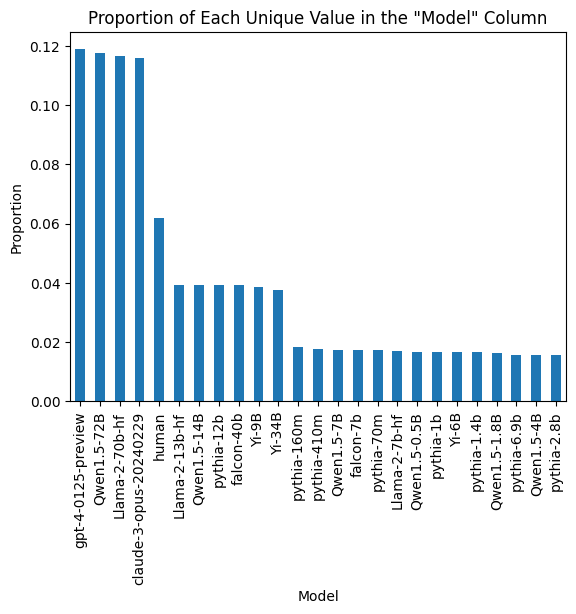

In [25]:
# Plot proportion of each unique value in the "model" column
model_proportions = df['model'].value_counts(normalize=True)
model_proportions.plot(kind='bar')
plt.title('Proportion of Each Unique Value in the "Model" Column')
plt.xlabel('Model')
plt.ylabel('Proportion')
plt.show()

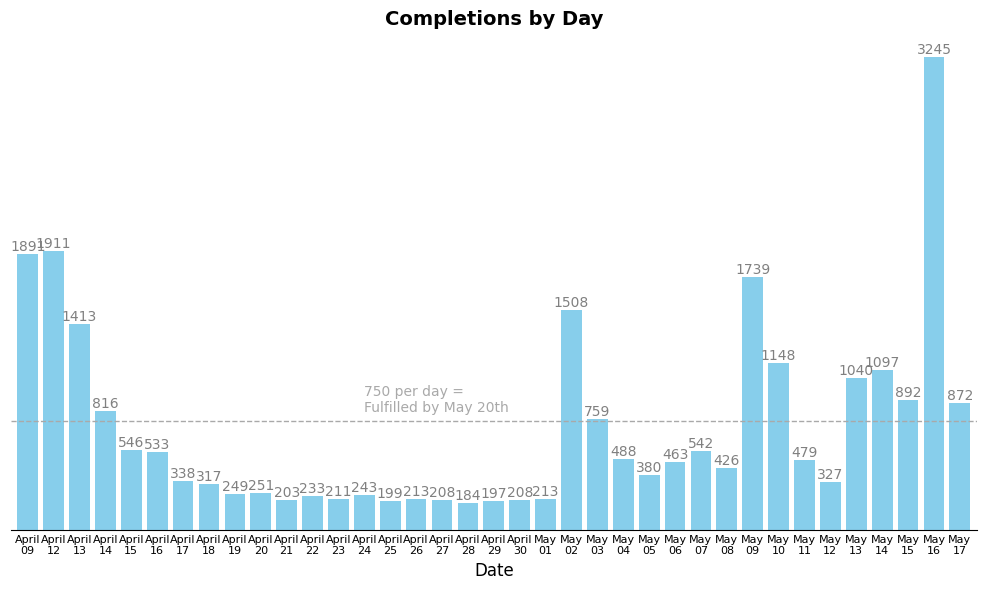

In [26]:
# plot the frequency of start dates as a bar chart and label each bar with the number it represents
# adhering to the principles of Edward Tufte

df['StartDate'] = pd.to_datetime(df['StartDate'])
start_date_counts = df['StartDate'].dt.date.value_counts().sort_index()

# Create a more attractive bar chart with minimalist design
fig, ax = plt.subplots(figsize=(10, 6))
start_date_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.8)

# Remove all unnecessary chartjunk
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().tick_left()
ax.axes.get_yaxis().set_visible(False)
plt.xticks(rotation=0, fontsize=8)
plt.tick_params(axis='x', which='both', length=0)

# Set axis labels and title
plt.title('Completions by Day', fontsize=14, weight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Completions', fontsize=12)

# Format x-axis tick labels to "month day"
ax.set_xticklabels([date.strftime('%B\n%d') for date in start_date_counts.index])

# Annotate each bar with the number it represents using a subtle color and proper alignment
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='gray', fontsize=10)

# Add a light grid to improve readability, adhering to Tufte's principle of fine lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Add dashed horizontal lines at y=1428 and y=1071 with matching text label colors
ax.axhline(y=750, color='darkgrey', linestyle='--', linewidth=1)

# Add text labels for the horizontal lines with matching colors
label_1428 = ax.text(x=13, y=825 + 65, s="750 per day =\nFulfilled by May 20th", va='center', ha='left', color='darkgrey')

# Show the plot with a tight layout to ensure all elements are nicely fit
plt.tight_layout()
plt.show()

# save as a pdf
fig.savefig('completions_by_day.pdf')

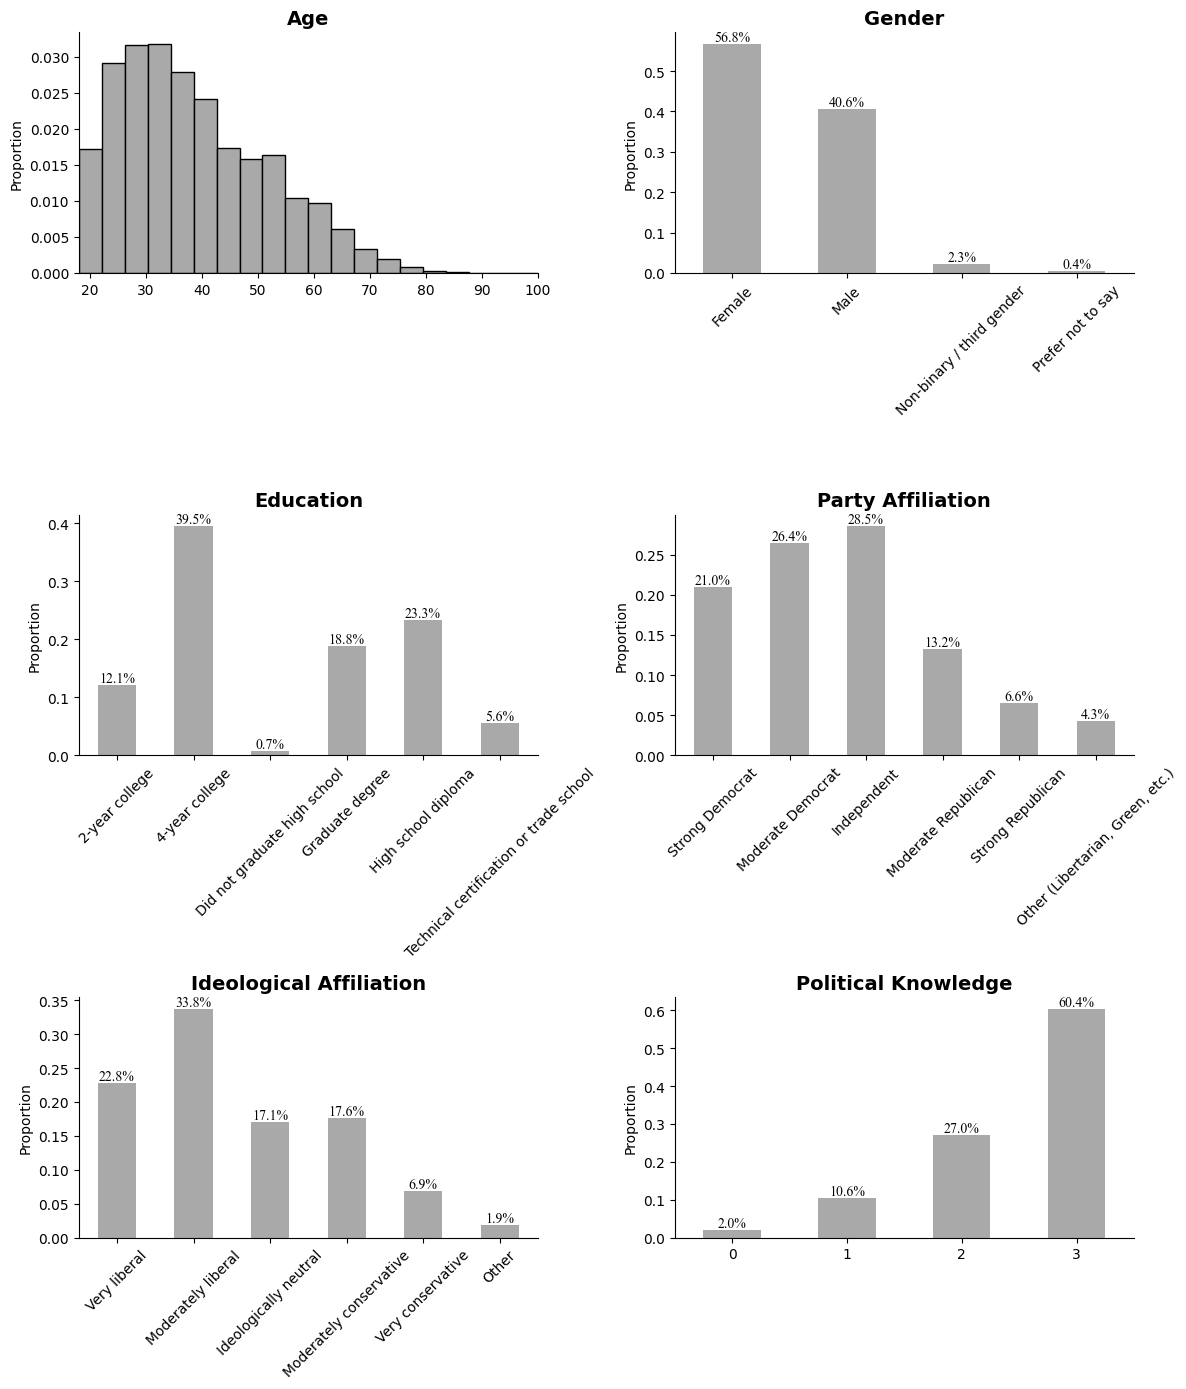

In [27]:
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# Titles for each subplot
titles = [
    'Age', 'Gender', 'Education', 
    'Party Affiliation', 'Ideological Affiliation', 'Political Knowledge'
]

# Columns to create bar charts for
columns = ['age', 'gender', 'education', 'party_affiliation', 'ideo_affiliation', 'political_knowledge']

# Convert 'age' to numeric, coercing errors to NaN (which will be excluded from the histogram)
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Define the specific order for the 'party_affiliation' and 'ideo_affiliation' plots
party_affiliation_order = [
    'Strong Democrat', 'Moderate Democrat', 'Independent', 
    'Moderate Republican', 'Strong Republican',  'Other (Libertarian, Green, etc.)'
]
ideo_affiliation_order = [
    'Very liberal', 'Moderately liberal', 'Ideologically neutral',
    'Moderately conservative', 'Very conservative', 'Other'
]

# Convert the 'party_affiliation' and 'ideo_affiliation' columns to categorical types with the defined order
df['party_affiliation'] = pd.Categorical(df['party_affiliation'], categories=party_affiliation_order, ordered=True)
df['ideo_affiliation'] = pd.Categorical(df['ideo_affiliation'], categories=ideo_affiliation_order, ordered=True)

# Set font family to Times New Roman for all text elements
plt.rcParams['font.family'] = 'Times New Roman'

# Loop through the columns and create a bar chart or histogram for each
for ax, col, title in zip(axes.flatten(), columns, titles):
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if col == 'age':
        # Plot as a histogram with proportions on the y-axis and dark grey bars
        df[col].dropna().plot(kind='hist', bins=20, ax=ax, edgecolor='black', density=True, color='darkgrey')
        # Set x-axis limits to avoid having too many labels
        ax.set_xlim(df[col].min(), df[col].max())
        # Set x-axis ticks to be more manageable
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    else:
        # Get value counts for the column and sort by index
        value_counts = df[col].value_counts(normalize=True).sort_index()
        # Create bar chart with dark grey bars
        bars = value_counts.plot(kind='bar', ax=ax, color='darkgrey')
        # Add proportion labels on top of the bars
        for bar in bars.patches:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_height(),
                    f"{bar.get_height() * 100:.1f}%",
                    ha='center', va='bottom',
                    color='black', fontsize=10)
    
    # Set title with bold font and increased font size
    ax.set_title(title, fontweight='bold', fontsize=14)
    # Remove x-axis label
    ax.set_xlabel('')
    # Set y-axis label to 'Proportion'
    ax.set_ylabel('Proportion')
    # Rotate x-axis labels for better readability if not a histogram
    if col == 'political_knowledge':
        ax.tick_params(axis='x', rotation=0)
    elif col == 'age':
        ax.tick_params(axis='x', rotation=0)
    else:
        ax.tick_params(axis='x', rotation=45)

# Adjust layout for a clean look
plt.tight_layout()

# Show the plot
plt.show()

# Save the plot as a PDF
fig.savefig('demographics.pdf')

In [28]:
# create a table showing the proportion of responses to the authorship question, excluding cases where model = human and condition = control
authorship_table = df[(df['model'] != 'human') & (df['condition'] != 'control')]['authorship'].value_counts(normalize=True) * 100
print(authorship_table)



authorship
An AI language model                    22.864282
A political science graduate student    17.410026
A political journalist                  16.851842
I'm not sure                            16.442507
A political strategist / consultant     13.534634
A politician                             9.425336
A college Professor                      3.471373
Name: proportion, dtype: float64


In [29]:
# create the same table from above bu with only cases where model = human and condiiton does not equal control
authorship_table_human = df[(df['model'] == 'human') & (df['condition'] != 'control')]['authorship'].value_counts(normalize=True) * 100
print(authorship_table_human)
    

authorship
An AI language model                    20.403226
I'm not sure                            20.403226
A political journalist                  17.258065
A political science graduate student    16.209677
A political strategist / consultant     13.467742
A politician                             8.306452
A college Professor                      3.951613
Name: proportion, dtype: float64


In [30]:
# Reset the index of both DataFrames to avoid duplicate index values
attrition_df['attrition'] = 1
df['attrition'] = 0
attrition_df = attrition_df.reset_index(drop=True)
df = df.reset_index(drop=True)

#update the names in the model column of attrition_df using the model_mapping dictionary
attrition_df['model'] = attrition_df['model'].map(model_mapping).fillna(attrition_df['model'])

# Now concatenate the DataFrames
df_with_attrition = pd.concat([df, attrition_df], ignore_index=True)

#duplicate the condition column in df_with_attrition and call it condition1
df_with_attrition['condition1'] = df_with_attrition['condition']

# if condition1 = AI, replace it with the value from the "model" column
df_with_attrition.loc[df_with_attrition['condition1'] == 'AI', 'condition1'] = df_with_attrition['model']

#print the number of unique values in the condition1 column
print(df_with_attrition['condition1'].nunique())
#print the unique values in the condition1 column
print(df_with_attrition['condition1'].unique())


# drop the rows from df_with_attrition where the condition1 column is equal to pythia-70m
# df_with_attrition = df_with_attrition[df_with_attrition['condition1'] != 'pythia-70m']

26
['pythia-410m' 'gpt-4-0125-preview' 'pythia-1.4b' 'Llama-2-70b-hf'
 'claude-3-opus-20240229' 'pythia-12b' 'control' 'Qwen1.5-72B'
 'Qwen1.5-0.5B' 'Qwen1.5-7B' 'Qwen1.5-1.8B' 'falcon-7b' 'Qwen1.5-14B'
 'Yi-6B' 'Yi-9B' 'pythia-6.9b' 'Llama-2-7b-hf' 'human' 'pythia-160m'
 'pythia-2.8b' 'Qwen1.5-4B' 'falcon-40b' 'Yi-34B' 'pythia-1b'
 'Llama-2-13b-hf' 'pythia-70m']


In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the linear model
model = smf.ols('attrition ~ 1 + condition1', data=df_with_attrition).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

                sum_sq       df        F    PR(>F)
condition1    0.313809     25.0  1.76117  0.010813
Residual    186.335637  26144.0      NaN       NaN
